In [1]:
import os
import csv  
import pdb
from multiprocessing import Pool

import numpy as np
import pandas as pd
import scipy.optimize as op
import scipy.special as spec
from scipy import stats
from scipy.interpolate import RegularGridInterpolator
import scipy.ndimage
from scipy.linalg import cho_factor, cho_solve

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator
import seaborn as sns
import corner

import astropy
from astropy import stats as astrostats
from astropy.timeseries import LombScargle

import emcee
import celerite
import radvel
import occur

%matplotlib inline

# Assuming a polished list of known planets and candidates in the legacy sample, explore and visualize properties such as mass, host star metallicity, etc.

In [2]:
data = pd.read_csv('../CLSI/legacy_tables/system_props.csv')

In [3]:
specmatch = pd.read_csv('~/Academics/Astronomy/Planets/CLSI/legacy_tables/legacy_specmatch_medians.csv')
smsyn = specmatch.query('teff_emp > 4700')
smemp = specmatch.query('teff_emp <= 4700')
fe_select = specmatch['fe_c'].to_list()

In [4]:
objects = pd.read_csv('../CLSI/legacy_tables/planet_list.csv')
trends = pd.read_csv('../CLSI/legacy_tables/trend_list.csv')

## Sort the planets into real, new candidates, known.

In [5]:
objects_real   = objects.query('status != "N" and status != "A" and status != "R"').reset_index(drop=True)
objects_good   = objects_real.query('mass != "nan"').reset_index(drop=True)
planets_s      = objects_good.query('(status == "S" or status == "SS") and mass > 10').reset_index(drop=True)
planets        = objects_good.query('status != "S" and status != "SS" and hostname != "66428"').reset_index(drop=True)
planets_old    = planets.query('status == "K"').reset_index(drop=True)
planets_new    = planets.query('status == "C" or status == "J"').reset_index(drop=True)

In [7]:
np.amin(planets.query('axis > 0.016').axis)

0.028485978310000007

In [11]:
planets_s.query('hostname == "31412"')

,Unnamed: 0,hostname,status,pl_index,mass,mass_med,mass_minus,mass_plus,axis,axis_med,...,e_68,insol,insol_med,insols_minus,insols_plus,teq,teq_med,teq_minus,teq_plus,post_path
23,176,31412,S,1.0,358.558401,359.890592,350.863701,368.761957,19.959228,19.775427,...,0.978456,0.004478,0.004561,0.004187,0.00496,2.500328,2.488881,0.004187,0.00496,/data/user/lrosenth/legacy/final_run/31412/314...


## Pull Specmatch metallicities into planet properties. In 'Masses_good_with_specmatch'.

In [6]:
merge_columns = list(planets.columns)
merge_columns.append('fe')
m_good_spec = pd.DataFrame(columns=merge_columns)

planets['name'] = planets['hostname']
m_good_spec = pd.merge(planets, specmatch, on=['name'])

In [7]:
good_spec_filter = m_good_spec.query('fe > -0.6 and (status == "K" or status == "C")')#axis < 5 and mass > 0.1 
print(len(m_good_spec), len(good_spec_filter))

180 162


In [8]:
len(planets)

180

## Examine mass and period distributions.

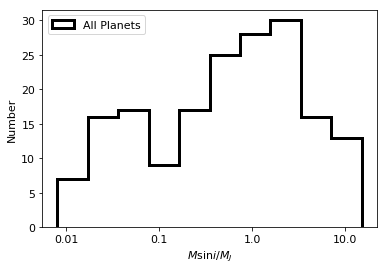

In [42]:
fig, ax = plt.subplots()
ax.hist(np.log10(planets.query('mass < 15')['mass']), 
        bins=10, density=False, histtype='step', range=(np.log10(0.008), np.log10(15)),
        lw=3, color='black', alpha=1, label='All Planets')

matplotlib.rcParams.update({'font.size': 11})
ax.set(xlabel=r'$M\mathrm{sin}i/M_J$', 
          ylabel='Number')
matplotlib.rcParams.update({'font.size': 11})
#ax.set_title(r'$M$sin$i$ > 0.1 $M_J$, a > 0.1 AU')
        
def format_fn(tick_val, tick_pos):
    return str(10**tick_val)
    #return str(int(10**tick_val))
ax.xaxis.set_major_formatter(FuncFormatter(format_fn))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))   
matplotlib.rcParams.update({'font.size': 11})
ax.legend(loc=2)

fig.savefig('plots/mass_histogram_all.png', dpi=500, bbox_inches='tight')

In [24]:
masses_close = planets.query('axis < 1 and mass < 15')
masses_mid   = planets.query('axis >= 1 and axis < 3 and mass < 15')
masses_far   = planets.query('axis >= 3 and mass < 15')

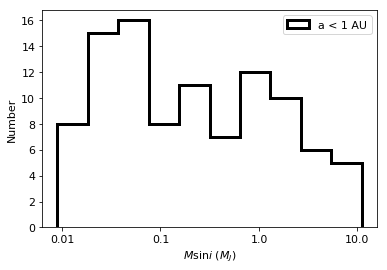

In [25]:
mclose = masses_close.mass
#thresh_close = np.log10(0.075) #50% completeness threshold

fig, ax = plt.subplots()
ax.hist(np.log10(mclose), bins=10, density=False, histtype='step',
        lw=3, color='black', alpha=1, label='a < 1 AU')

matplotlib.rcParams.update({'font.size': 11})
ax.set(xlabel=r'$M\mathrm{sin}i\ (M_J)$', 
          ylabel='Number')
matplotlib.rcParams.update({'font.size': 11})
#ax.set_title(r'$M$sin$i$ > 0.1 $M_J$, a > 0.1 AU')
        
def format_fn(tick_val, tick_pos):
    return str(10**tick_val)
    
ax.xaxis.set_major_formatter(FuncFormatter(format_fn))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))   
matplotlib.rcParams.update({'font.size': 11})
ax.legend(loc=1)

fig.savefig('plots/close_histogram.png', dpi=500, bbox_inches='tight')

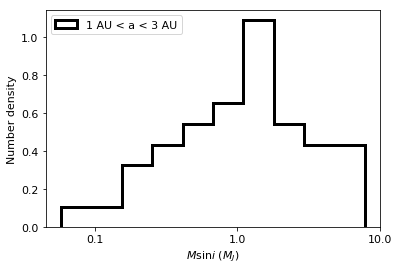

In [26]:
mmid = masses_mid.mass
thresh_mid = np.log10(0.15) #50% completeness threshold

fig, ax = plt.subplots()
ax.hist(np.log10(mmid), bins=10, density=True, histtype='step',
        lw=3, color='black', alpha=1, label='1 AU < a < 3 AU')

matplotlib.rcParams.update({'font.size': 11})
ax.set(xlabel=r'$M\mathrm{sin}i\ (M_J)$', 
          ylabel='Number density')
matplotlib.rcParams.update({'font.size': 11})
        
def format_fn(tick_val, tick_pos):
    return str(10**tick_val)
    
ax.xaxis.set_major_formatter(FuncFormatter(format_fn))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))   
matplotlib.rcParams.update({'font.size': 11})
ax.legend(loc=2)

fig.savefig('plots/mid_histogram.png', dpi=500, bbox_inches='tight')

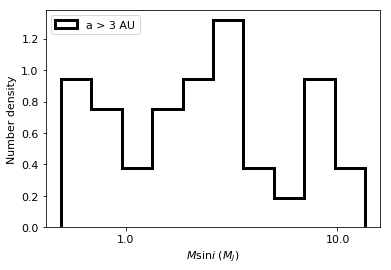

In [27]:
mfar = masses_far.mass
thresh_far = np.log10(1.2) #50% completeness threshold

fig, ax = plt.subplots()
ax.hist(np.log10(mfar), bins=10, density=True, histtype='step',
        lw=3, color='black', alpha=1, label='a > 3 AU')

matplotlib.rcParams.update({'font.size': 11})
ax.set(xlabel=r'$M\mathrm{sin}i\ (M_J)$', 
          ylabel='Number density')
matplotlib.rcParams.update({'font.size': 11})
        
def format_fn(tick_val, tick_pos):
    return str(10**tick_val)

ax.xaxis.set_major_formatter(FuncFormatter(format_fn))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))   
matplotlib.rcParams.update({'font.size': 11})
ax.legend(loc=2)

fig.savefig('plots/far_histogram.png', dpi=500, bbox_inches='tight')

## Do some preliminary work on giant multis.

In [178]:
planets_big_all   = planets.query('mass > 0.1')
planets_small_all = planets.query('mass <= 0.1')

names_big_all = np.unique(planets_big_all.hostname)
nplanets_big_all = np.array(planets_big_all.groupby('hostname').count()['status'])
db_nplanets_big_all = pd.DataFrame({'hostname':names_big_all, 'nplanets':nplanets_big_all})

names_small_all = np.unique(planets_small_all.hostname)
nplanets_small_all = np.array(planets_small_all.groupby('hostname').count()['status'])
db_nplanets_small_all = pd.DataFrame({'hostname':names_small_all, 'nplanets':nplanets_small_all})

# Do same nplanets thingy for all planets, no mass cuts.
names_all = np.unique(planets.hostname)
nplanets_all = np.array(planets.groupby('hostname').count()['status'])
db_nplanets_all = pd.DataFrame({'hostname':names_all, 'nplanets':nplanets_all})

planets_all       = pd.merge(planets, db_nplanets_all, on='hostname').reset_index()
planets_big_all   = pd.merge(planets_big_all, db_nplanets_big_all, on='hostname').reset_index()
planets_small_all = pd.merge(planets_small_all, db_nplanets_small_all, on='hostname').reset_index()

db_nplanets_all       = None
db_nplanets_big_all   = None
db_nplanets_small_all = None

In [179]:
planets_big_multi_all = planets_big_all.query('nplanets > 1')
planets_multi_all     = planets_all.query('nplanets > 1')

In [181]:
planets_outer = planets_big_multi_all.query('axis > 10')

In [182]:
prob_outer = len(planets_big_multi_all.query('hostname in @planets_outer.hostname \
                 and axis < 0.1'))/float(len(planets_outer))
sig_outer = np.sqrt(float(len(planets_big_multi_all.query('hostname in @planets_outer.hostname \
                    and axis < 0.1')))) / len(planets_outer)
print(prob_outer, '+\-', sig_outer)

0.3333333333333333 +\- 0.3333333333333333


## P(HJ | 10 AU > Outer > 4.64 AU)

In [183]:
planets_med = planets_big_multi_all.query('axis < 10 and axis > 4.64')

In [184]:
prob_med = len(planets_big_multi_all.query('hostname in @planets_med.hostname \
               and axis < 0.1'))/float(len(planets_med))
sig_med = np.sqrt(len(planets_big_multi_all.query('hostname in @planets_med.hostname \
                  and axis < 0.1')))/float(len(planets_med))
print(prob_med, '+\-', sig_med)

0.07692307692307693 +\- 0.07692307692307693


## P(HJ | 4.64 AU > Outer > 2.15 AU)

In [185]:
planets_inner = planets_big_multi_all.query('axis < 4.64 and axis > 2.15')

In [186]:
prob_inner = len(planets_big_multi_all.query('hostname in @planets_inner.hostname \
                 and axis < 0.1'))/float(len(planets_med))
sig_inner = np.sqrt(len(planets_big_multi_all.query('hostname in @planets_inner.hostname \
                 and axis < 0.1')))/float(len(planets_med))
print(prob_inner, '+\-', sig_inner)

0.15384615384615385 +\- 0.10878565864408424


## How many stars that host small planets have linear or parabolic trends?

In [8]:
trend_names = np.unique(trends.hostname)
small_names = np.unique(planets.query('mass < 0.1 and hostname != "143761"').hostname)

In [9]:
[name for name in trend_names if name in small_names]

['156668', '34445', '45184']

### The 156668 trend is modeling out an activity alias, and the 45184 trend might be activity itself.

## Inner super-Earths and outer gas giants

In [83]:
supers = planets.query('mass < 0.1 and hostname != "143761"').reset_index(drop=True)
# HD 143761 has an inner giant and an outer small planet. Weirdo.
supernames = list(supers.hostname)
print(len(supers), len(np.unique(supers.hostname)))

41 27


In [84]:
outers = planets.query('mass >= 0.1 and hostname in @supernames and hostname != "143761"').reset_index(drop=True)
outernames = list(outers.hostname) # and axis > 0.3

In [85]:
pairs = planets.query('hostname in @outernames').reset_index(drop=True)
solos = planets.query('mass < 0.1 and not (hostname in @outernames)')

## Preliminary statistics.

In [86]:
all_outers  = planets.query('mass >= 0.1 and axis > 0.23 and hostname != "143761"')
outernames = list(all_outers.hostname)
inners = planets.query('mass < 0.1 and hostname in @outernames and hostname != "143761"').reset_index(drop=True)

In [10]:
print(len(supers), 'small planets,', len(outers), 'outer companions,', len(outers)/len(supers))

43 small planets, 14 outer companions, 0.32558139534883723


In [11]:
print(len(np.unique(supers.hostname)), 'small planet systems,', len(np.unique(outers.hostname)), 
      'inner and outer systems,', len(np.unique(outers.hostname))/len(np.unique(supers.hostname)))

29 small planet systems, 9 inner and outer systems, 0.3103448275862069


In [12]:
print(len(all_outers), 'cold giants,', len(inners), 'inner companions,', len(inners)/len(all_outers))

113 cold giants, 14 inner companions, 0.12389380530973451


In [13]:
print(len(np.unique(all_outers.hostname)), 'cold giant systems,', len(np.unique(inners.hostname)), 
      'inner and outer systems,', len(np.unique(inners.hostname))/len(np.unique(all_outers.hostname)))

81 cold giant systems, 9 inner and outer systems, 0.1111111111111111


## Compare metallicities of all planet hosts and inner-outer pair hosts.

In [16]:
m_spec_pairs = m_good_spec.query('hostname in @outernames')

NameError: name 'm_good_spec' is not defined

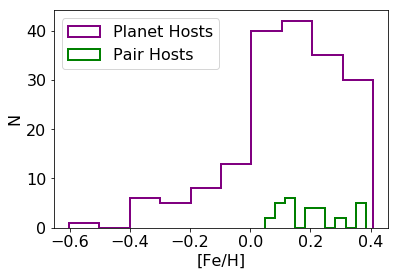

In [58]:
fig, ax = plt.subplots()
ax.hist(m_good_spec.fe_c, density=False, histtype='step', lw=2, color='purple', label='Planet Hosts')
ax.hist(m_spec_pairs.fe_c, density=False, histtype='step', lw=2, color='green', label='Pair Hosts')
ax.set_xlabel('[Fe/H]')
ax.set_ylabel('N')
ax.legend(loc=2)
fig.savefig('analysis_plots/pair_fe_histogram.pdf')

## Sketch code to stack injections on cadence, with msini & a.

In [149]:
def save_completeness(listf, outf, stellarf, recdir):
    names = pd.read_csv(listf)
    stars = pd.read_csv(stellarf)
    
    all_recoveries = pd.DataFrame()
    
    for name in names['name']:
        recoveries = pd.read_csv(recdir + '/' + name + '/recoveries.csv')
        mstar = float(stars.query('name == @name')['mass_c'])
        
        recoveries['inj_msini'] = radvel.utils.Msini(recoveries['inj_k'],
                                                     recoveries['inj_period'],
                                                     mstar, recoveries['inj_e'],
                                                     Msini_units='jupiter')
        recoveries['rec_msini'] = radvel.utils.Msini(recoveries['rec_k'],
                                                     recoveries['rec_period'],
                                                     mstar, recoveries['rec_e'],
                                                     Msini_units='jupiter')
        recoveries['inj_au'] = radvel.utils.semi_major_axis(recoveries['inj_period'], mstar)
        recoveries['rec_au'] = radvel.utils.semi_major_axis(recoveries['rec_period'], mstar)    
        
        all_recoveries = all_recoveries.append(recoveries).reset_index(drop=True)
        
    all_recoveries.to_csv(outf)

## Create class for evaluating a completeness grid across injections and recoveries. Clone of BJ's code in RVSearch, except passing in msini and axis as inputs, rather than computing with a single stellar mass.

In [6]:
class Completeness(object):
    """Object to handle a suite of injection/recovery tests

    Args:
        recoveries (DataFrame): DataFrame of injection/recovery tests from Injections class
        xcol (string): (optional) column name for independent variable. Completeness grids and
            interpolator will work in these axes
        ycol (string): (optional) column name for dependent variable. Completeness grids and
            interpolator will work in these axes

    """   
    def __init__(self, recoveries, xcol='inj_au', ycol='inj_msini'):

        self.recoveries = recoveries
        
        self.xcol = xcol
        self.ycol = ycol

        self.grid = None
        self.interpolator = None    

    def completeness_grid(self, xlim, ylim, resolution=20, xlogwin=0.5, ylogwin=0.5):

        xgrid = np.logspace(np.log10(xlim[0]),
                            np.log10(xlim[1]),
                            resolution)
        ygrid = np.logspace(np.log10(ylim[0]),
                            np.log10(ylim[1]),
                            resolution)

        xinj = self.recoveries[self.xcol]
        yinj = self.recoveries[self.ycol]

        good = self.recoveries['recovered']
        
        z = np.zeros((len(ygrid), len(xgrid)))
        last = 0
        for i,x in enumerate(xgrid):
            for j,y in enumerate(ygrid):
                xlow  = 10**(np.log10(x) - xlogwin/2)
                xhigh = 10**(np.log10(x) + xlogwin/2)
                ylow  = 10**(np.log10(y) - ylogwin/2)
                yhigh = 10**(np.log10(y) + ylogwin/2)

                xbox = yinj[np.where((xinj <= xhigh) & (xinj >= xlow))[0]]
                if len(xbox) == 0 or y > max(xbox) or y < min(xbox):
                    z[j, i] = np.nan
                    continue

                boxall = np.where((xinj <= xhigh) & (xinj >= xlow) &
                                  (yinj <= yhigh) & (yinj >= ylow))[0]
                boxgood = np.where((xinj[good] <= xhigh) &
                                   (xinj[good] >= xlow) & (yinj[good] <= yhigh) &
                                   (yinj[good] >= ylow))[0]

                if len(boxall) > 10:
                    z[j, i] = float(len(boxgood))/len(boxall)
                    last = float(len(boxgood))/len(boxall)
                else:
                    z[j, i] = np.nan

        self.grid = (xgrid, ygrid, z)
    
    def interpolate(self, x, y, refresh=False):

        if self.interpolator is None or refresh:
            assert self.grid is not None, "Must run Completeness.completeness_grid()."
            zi = self.grid[2].T
            self.interpolator = RegularGridInterpolator((self.grid[0], self.grid[1]), zi, 
                                                        bounds_error=False, fill_value=0.001) # Maybe don't set fill
        
        return self.interpolator(np.array([np.atleast_1d(x), np.atleast_1d(y)]).T)

## Sketch DFM occurrence likelihood, first with broken power law, then nonparametric.

In [129]:
def occbroken(a, theta):
    return theta[0]*(a**theta[1])*(1 - np.exp(-(a/theta[2])**theta[3]))

def nll(theta, x, y, yerr):
    return 0.5*np.sum((y-occbroken(x, theta))**2*yerr**-2 + np.log(2*np.pi*yerr**2))

def fit_broken(x, y, yerr, C_init=10, beta_init=0, a0_init=1, gamma_init=2): 
    fit = op.minimize(nll, [C_init, beta_init, a0_init, gamma_init], args=(x, y, yerr),
                      method='Powell', options={'xtol': 1e-8, 'disp': True})
    return fit.x
giants = planets.query('mass >= 0.1')
num = np.histogram(np.log(giants.axis), bins=9, range=np.log([0.1,30]), density=False)
yerr = 0.5*np.ones(9)
fit = fit_broken(num[1][:-1], num[0], yerr)

In [130]:
num

(array([ 6,  9,  9, 25, 22, 23, 17,  5,  2]),
 array([-2.30258509, -1.66883148, -1.03507788, -0.40132427,  0.23242934,
         0.86618295,  1.49993656,  2.13369017,  2.76744377,  3.40119738]))

In [131]:
fit

array([13.66842683,  0.99999872,  6.23606131,  7.23606131])

In [143]:
class BrokenPowerLaw(object):
    """Do hierarchical Bayesian sampling of occurrence posteriors, based on DFM et al. 2014.
    Args:
        pop (pandas DataFrame): dataframe of planet parameter chains

    """
    def __init__(self, pop, completeness, chainname='powerlaw_chains.csv'):
        # TO-DO: Replace single-param planets with paths to posteriors.
        self.pop          = pop 
        self.completeness = completeness 
        self.completeness.completeness_grid([0.01, 40], [3, 7000])
        # Fill in completeness nans.
        self.completeness.grid[2][np.isnan(self.completeness.grid[2])] = 1.  
                
        axis  = []
        msini = []
        self.planetnames = np.unique([x[:-2] + x[-1] for x in pop.columns]) 
        self.starnames   = np.unique([x[:-1] for x in self.planetnames])
        self.nplanets    = len(self.planetnames)
        self.nsamples    = len(self.pop)
        self.nstars      = len(self.starnames)
        
        medians = pop.median() 
        for name in self.planetnames:
            axis.append(medians[[name[:-1] + 'a' + name[-1]]][0])
            msini.append(medians[[name[:-1] + 'M' + name[-1]]][0])            
        self.pop_med = pd.DataFrame.from_dict({'axis':axis, 'msini':msini})
        
        self.chainname = chainname
        
    def max_like(self):
        # FIGURE THIS OUT
        C_0 = 80
        beta_0 = -0.2
        a0_0 = 0.8
        gamma_0 = 2. 
        self.mlvalues = np.array([C_0, beta_0, a0_0, gamma_0])
        
    def occurrence(self, axis, mass, theta):
        broken = theta[0]*axis**theta[1]*(1 - np.exp(-(axis/theta[2])**theta[3]))
        broken[axis < 0.1] = 0.01
        broken[axis > 30.] = 0.01
        broken[mass < 0.1] = 0.01
        return broken 

    def lnlike(self, theta): 
        sums = []
        for planet in self.planetnames:
            probs = []
            sample_a = np.array(self.pop[planet[:-2] + '_a' + planet[-1]])
            sample_M = np.array(self.pop[planet[:-2] + '_M' + planet[-1]])
            probs = self.completeness.interpolate(sample_a, sample_M) * \
                                  self.occurrence(sample_a, sample_M, theta)
            sums.append(np.sum(probs))          
             
        ll = np.sum(np.log(np.array(sums)/self.nsamples))
        if not np.isfinite(ll):
            print('BAD!')
            return -np.inf
        return ll
    
    def lnprior(self, theta):
        if theta[0] <= 0. or theta[0] < 500 or theta[1] > 1 or theta[1] < -5 or \
           theta[2] < 0.05 or theta[2] > 5 or theta[3] > 8 or theta[3] <= 0.5:
            return -np.inf
        return 0
    
    def lnpost(self, theta):
        return self.lnlike(theta) + self.lnprior(theta)
    
    def sample(self, parallel=False, save=True):
        nwalkers = 25
        ndim = 4
        pos = np.array([np.abs(self.mlvalues + 0.05*np.random.randn(ndim)) \
                                           for i in np.arange(nwalkers)])
        if parallel:
            with Pool(8) as pool:
                self.sampler = emcee.EnsembleSampler(nwalkers, ndim, self.lnpost, pool=pool)
                self.sampler.run_mcmc(pos, 1000, progress=True)
                self.chains = self.sampler.chain[:, 100:, :].reshape((-1, ndim))
        else:
            self.sampler = emcee.EnsembleSampler(nwalkers, ndim, self.lnpost)
            self.sampler.run_mcmc(pos, 1000, progress=True)           
            self.chains = self.sampler.chain[:, 100:, :].reshape((-1, ndim))    
            
        if save:
            chaindb = pd.DataFrame() 
            chaindb['C'] = self.chains[:, 0]
            chaindb['beta'] = self.chains[:, 1]
            chaindb['a0'] = self.chains[:, 2]
            chaindb['gamma'] = self.chains[:, 3]
            chaindb.to_csv(self.chainname)           
    
    def run(self):
        self.max_like()
        self.sample()                       

In [116]:
class Hierarchy(object):
    """Do hierarchical Bayesian sampling of occurrence posteriors, based on DFM et al. 2014.
    Args:
        pop (pandas DataFrame): dataframe of planet parameter chains

    """
    def __init__(self, pop, completeness, res=4, bins=np.array([[[np.log(0.02), np.log(20)], 
                                                                 [np.log(2.), np.log(6000)]]]),
                                                                  chainname='occur_chains.csv'):
        # TO-DO: Replace single-param planets with paths to posteriors.
        self.pop          = pop # Replace pairs of m & a with chains
        self.completeness = completeness # Completeness grid, defined as class object below.
        self.completeness.completeness_grid([0.01, 40], [3, 7000])
        # Fill in completeness nans.
        self.completeness.grid[2][np.isnan(self.completeness.grid[2])] = 1. #0.99
        
        
        self.res = res # Resolution for logarithmic completeness integration.
        self.bins = bins # Logarithmic bins in msini/axis space.
        self.nbins = len(self.bins)
        self.lna_edges = np.unique(self.bins[:, 0])
        self.lnm_edges = np.unique(self.bins[:, 1])
        self.nabins = len(self.lna_edges) - 1
        self.nmbins = len(self.lnm_edges) - 1
        #self.na = len(self.lna_edges)
        #self.nm = len(self.lnm_edges)
        
        # Compute bin centers and widths.
        self.bin_widths  = np.diff(self.bins)
        self.bin_centers = np.mean(self.bins, axis=2)
        self.bin_areas   = self.bin_widths[:,0]*self.bin_widths[:,1]
        
        # Pre-compute integrated completeness for each bin.
        self.Qints = np.zeros(self.nbins)
        for n, binn in enumerate(self.bins):
            for i in np.arange(4): #self.res
                for j in np.arange(4):
                    lna_av = binn[0][0] + (0.25*i + 0.125)*(binn[0][1] - binn[0][0])
                    lnm_av = binn[1][0] + (0.25*j + 0.125)*(binn[1][1] - binn[1][0])     
                    self.Qints[n] += (self.bin_areas[n][0]/self.res**2) * \
                                      self.completeness.interpolate(np.exp(lna_av), 
                                                                    np.exp(lnm_av))
                
        axis  = []
        msini = []
        self.planetnames = np.unique([x[:-2] + x[-1] for x in pop.columns]) 
        self.starnames   = np.unique([x[:-1] for x in self.planetnames])
        self.nplanets    = len(self.planetnames)
        self.nsamples    = len(self.pop)
        self.nstars      = len(self.starnames)
        
        medians = pop.median() # Along chain axis, once using chains.
        for name in self.planetnames:
            axis.append(medians[[name[:-1] + 'a' + name[-1]]][0])
            msini.append(medians[[name[:-1] + 'M' + name[-1]]][0])            
        self.pop_med = pd.DataFrame.from_dict({'axis':axis, 'msini':msini})
        
        self.chainname = chainname
        
    def max_like(self):
        ### Approximate max-likelihood occurrence values, with which to seed MCMC.
        mlvalues = np.empty((0, 2))
        for n, binn in enumerate(self.bins):
            # Integrate completeness across each individual bin.
            a1 = np.exp(binn[0][0])
            a2 = np.exp(binn[0][1])
            M1 = np.exp(binn[1][0])
            M2 = np.exp(binn[1][1])
            planets = self.pop_med.query('axis >= @a1 and axis < @a2 and \
                                         msini >= @M1 and msini < @M2')
            nplanets = len(planets)
            #ml  = np.log(nplanets/self.Qints[n])
            ml  = nplanets/self.Qints[n]
            uml = ml/np.sqrt(nplanets)
            if not np.isfinite(ml):
                ml = 0.01 #-7
            if not np.isfinite(uml):
                uml = 1.
            mlvalues = np.append(mlvalues, np.array([[ml, uml]]), axis=0) 
        mlvalues[np.isnan(mlvalues)] = 0.01
        mlvalues[mlvalues == 0] = 0.01
        self.mlvalues = mlvalues
        self.ceiling = np.amax(mlvalues)
        
    def occurrence(self, lna, lnm, theta):
        # Select appropriate bins, given lna & lnm.
        ia = np.atleast_1d(np.digitize(lna, self.lna_edges) - 1)
        im = np.atleast_1d(np.digitize(lnm, self.lnm_edges) - 1)
        iao = np.copy(ia)
        imo = np.copy(im)
        ia[ia < 0] = 0
        im[im < 0] = 0
        ia[ia > self.nabins - 1] = self.nabins - 1
        im[im > self.nmbins - 1] = self.nmbins - 1
        
        occur = theta[ia + im*self.nabins]
        # Return filler value for samples outside of the bin limits.
        occur[iao < 0] = 0.01 #-10
        occur[imo < 0] = 0.01 #-10
        occur[iao > self.nabins - 1] = 0.01 #-10
        occur[imo > self.nmbins - 1] = 0.01 #-10
        return occur    

    def lnlike(self, theta): 
        # Linear
        if np.any((theta <= 0) + (theta > 4*self.ceiling)):
            return -np.inf
        sums = []
        for planet in self.planetnames:
            #print(planet)
            probs = []
            sample_a = np.array(self.pop[planet[:-2] + '_a' + planet[-1]])
            sample_M = np.array(self.pop[planet[:-2] + '_M' + planet[-1]])
            probs = self.completeness.interpolate(sample_a, sample_M)*self.occurrence(
                                           np.log(sample_a), np.log(sample_M), theta)
            sums.append(np.sum(probs))
        
        # Integrate the observed occurrence over all bins. 
        nexpect = 0
        for i, binn in enumerate(self.bins):
            for j in np.arange(4): 
                for k in np.arange(4):
                    lna_av = binn[0][0] + (0.25*j + 0.125)*(binn[0][1] - binn[0][0])
                    lnm_av = binn[1][0] + (0.25*k + 0.125)*(binn[1][1] - binn[1][0])                    
                    nexpect += (self.bin_areas[i][0]/16)*self.completeness.interpolate(
                                                                        np.exp(lna_av), 
                                                                        np.exp(lnm_av))*self.occurrence(
                                                                        lna_av, lnm_av, theta)               
        ll = -nexpect + np.sum(np.log(np.array(sums)/self.nsamples))
        if not np.isfinite(ll):
            return -np.inf
        return ll
    
    def gpprior(self, theta, mu, l0, la, lm):
        ### Prior on occurrence. Gaussian process, for smoothly changing bin heights.
        if not 0 < mu < 4*self.ceiling:
            return -np.inf
        if not -2 < l0 < 6:
            return -np.inf
        if not -2 < la < 1:
            return -np.inf
        if not -2 < lm < 0:
            return -np.inf
        if np.any((theta <= 0) + (theta > 4*self.ceiling)): 
            return -np.inf

        # Compute Euclidean distance between bins, [∆i − ∆j]T Σ−1[∆i − ∆j]
        mini_inv_covar = np.array([[np.exp(la)**-1, 0], [0, np.exp(lm)**-1]])
        X              = np.matmul(self.bin_centers, mini_inv_covar)
        distance       = scipy.spatial.distance.cdist(X, X, 'sqeuclidean')
        
        K        = np.exp(l0)*np.exp(-0.5*distance)
        s, logdK = np.linalg.slogdet(K)
                
        y  = theta - mu
        F  = cho_factor(K)
        lp = -0.5*(logdK + np.dot(y, cho_solve(F, y)))
        
        if not np.isfinite(lp):
            return -np.inf
        return lp
    
    def lnpost(self, theta):
        return self.lnlike(theta) 
    
    def gppost(self, theta_gp):
        return self.lnlike(theta_gp[:-4]) + self.gpprior(theta_gp[:-4], 
                                                         theta_gp[-4], 
                                                         theta_gp[-3], 
                                                         theta_gp[-2], 
                                                         theta_gp[-1])
    
    def sample(self, gp=False, parallel=False, save=True):
        nwalkers = 4*self.nbins
        ndim = self.nbins 
        pos = np.array([np.abs(self.mlvalues[:, 0] + 0.01*np.random.randn(ndim)) \
                                                 for i in np.arange(nwalkers)]) + 0.01
        if gp:
            ndim += 4
            mu0 = np.mean(self.mlvalues[:, 0])
            l00 = 0
            la0 = 0
            lm0 = 0
            pos = np.append(pos, np.array([mu0, l00, la0, lm0]) + \
                                 np.array([0.05*np.random.randn(4) \
                                 for i in np.arange(nwalkers)]), axis=1)

        if parallel:
            with Pool(8) as pool:
                if gp:
                    self.sampler = emcee.EnsembleSampler(nwalkers, ndim, self.gppost, pool=pool)
                else:
                    self.sampler = emcee.EnsembleSampler(nwalkers, ndim, self.lnpost, pool=pool)
                self.sampler.run_mcmc(pos, 1000, progress=True)
                self.chains = self.sampler.chain[:, 100:, :].reshape((-1, ndim))
        else:
            if gp:
                self.sampler = emcee.EnsembleSampler(nwalkers, ndim, self.gppost)
            else:
                self.sampler = emcee.EnsembleSampler(nwalkers, ndim, self.lnpost)
            self.sampler.run_mcmc(pos, 1000, progress=True)           
            self.chains = self.sampler.chain[:, 100:, :].reshape((-1, ndim))    
            
        if save:
            chaindb = pd.DataFrame() 
            for n, binn in enumerate(self.bins):
                chaindb['gamma{}'.format(n)] = self.chains[:, n]
            if gp:
                chaindb['lmu)'] = self.chains[:, -4]
                chaindb['ll0)'] = self.chains[:, -3]
                chaindb['lla)'] = self.chains[:, -2]
                chaindb['llm)'] = self.chains[:, -1]
            chaindb.to_csv(self.chainname)           
    
    def run(self):
        self.max_like()
        self.sample()                       

In [117]:
def lngrid(min_a, max_a, min_M, max_M, resa, resm):
    lna1 = np.log(min_a)
    lna2 = np.log(max_a)
    lnM1 = np.log(min_M)
    lnM2 = np.log(max_M)
    
    da = (lna2 - lna1)/resa
    dM = (lnM2 - lnM1)/resm

    bins = []
    for i in np.arange(int(resa)):
        for j in np.arange(int(resm)):
            bins.append([[lna1 + i*da, lna1 + (i+1)*da], 
                         [lnM1 + j*dM, lnM1 + (j+1)*dM]])
            
    return np.array(bins)

In [55]:
recoveries_all = pd.read_csv('recoveries_all_earth.csv')
completey_all  = Completeness(recoveries_all)

In [56]:
samples_all = pd.read_csv('../samples_all_1000.csv').sample(500).reset_index(drop=True)
good_cols = [col for col in samples_all.columns if '_a' in col or '_M' in col]
samples_all = samples_all[good_cols]
samples_med = samples_all.median()
planetnames = np.unique([x[:-2] + x[-1] for x in samples_all.columns]) 

# Trim out planets that don't belong in each sample.
#columns_outers = [col for col in samples_all.columns if col[:-2] in list(supers.hostname)]
#columns_small = [col for col in samples_all.columns if col[:-2] in list(all_outers.hostname)]
columns_good = []
for planet in planetnames:
    a_col = planet[:-2] + '_a' + planet[-1]
    M_col = planet[:-2] + '_M' + planet[-1]
    if (samples_med[a_col] > 0.02) and (samples_med[M_col] > 0.09):
        columns_good.append(a_col)
        columns_good.append(M_col)
        
samples_all = samples_all[columns_good]

for col in columns_good:
    if '_M' in col:
        samples_all[col] *= 317.8

In [133]:
broken = BrokenPowerLaw(samples_all, completey_all)
broken.max_like()

In [134]:
broken.sample(parallel=True)

  2%|▏         | 19/1000 [00:18<16:20,  1.00it/s]Process ForkPoolWorker-51:
Process ForkPoolWorker-52:
Process ForkPoolWorker-55:
Traceback (most recent call last):
  File "/Users/lee/anaconda/lib/python3.7/site-packages/emcee/ensemble.py", line 545, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-132-b3e7117535c4>", line 69, in lnpost
    return self.lnlike(theta) + self.lnprior(theta)
  File "<ipython-input-132-b3e7117535c4>", line 52, in lnlike
    probs = self.completeness.interpolate(sample_a, sample_M) * \
  File "<ipython-input-6-5a5b4c2c2519>", line 72, in interpolate
    return self.interpolator(np.array([np.atleast_1d(x), np.atleast_1d(y)]).T)
  File "/Users/lee/anaconda/lib/python3.7/site-packages/scipy/interpolate/interpolate.py", line 2489, in __call__
    indices, norm_distances, out_of_bounds = self._find_indices(xi.T)
  File "/Users/lee/anaconda/lib/python3.7/site-packages/scipy/interpolate/interpolate.py", line 2532, in _find_indices


emcee: Exception while calling your likelihood function:
  params: [9.99325747e+01 1.22352922e-02 1.01808273e+00 1.97249359e+00]
  args: []
  kwargs: {}
  exception:


KeyboardInterrupt: 

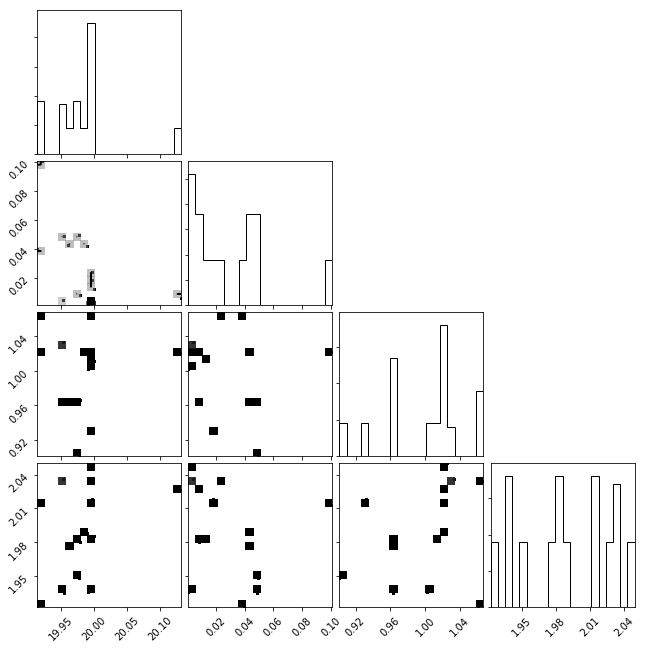

In [111]:
fig = corner.corner(broken.chains[10000:])

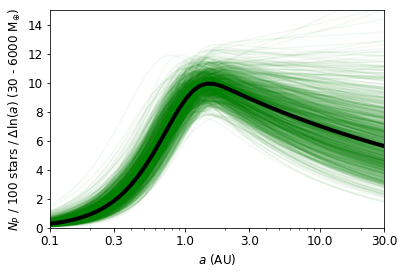

In [173]:
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_xticks((0.1, 0.3, 1, 3, 10, 30))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
#ax.set_yscale('log')
#ax.set_yticks((1, 0.3, 10))
#ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
#ax.get_yaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

ax.set_xlabel(r'$a$ (AU)')
ax.set_ylabel(r'$N_P$ / 100 stars / $\Delta$ln($a$) (30 - 6000 $\mathrm{M_{\oplus}}$)')

ax.set_xlim([0.1, 30])
ax.set_ylim([0, 15])

axes = np.logspace(-1, np.log10(30), num=50)
for i in np.arange(1000):
    #Draw mock parameters until we get the sampling to work.
    C = np.random.normal(80, 5)
    beta = np.random.normal(-0.2, 0.1)
    a0 = np.random.normal(0.8, 0.1)
    gamma = np.random.normal(2, 0.2)
    ax.plot(axes, (100/719)*occbroken(axes, [C, beta, a0, gamma]), alpha=0.05, color='green')
ax.plot(axes, (100/719)*occbroken(axes, [80, -0.2, 0.8, 2]), color='black', lw=4)

In [118]:
allbins = lngrid(0.03, 30., 30., 6000, 11, 1) 
hierarchical_one = Hierarchy(samples_all, completey_all, bins=allbins)

hierarchical_one.max_like()

In [68]:
hierarchical_one.sample(parallel=True, gp=False)

100%|██████████| 1000/1000 [45:39<00:00,  2.74s/it]


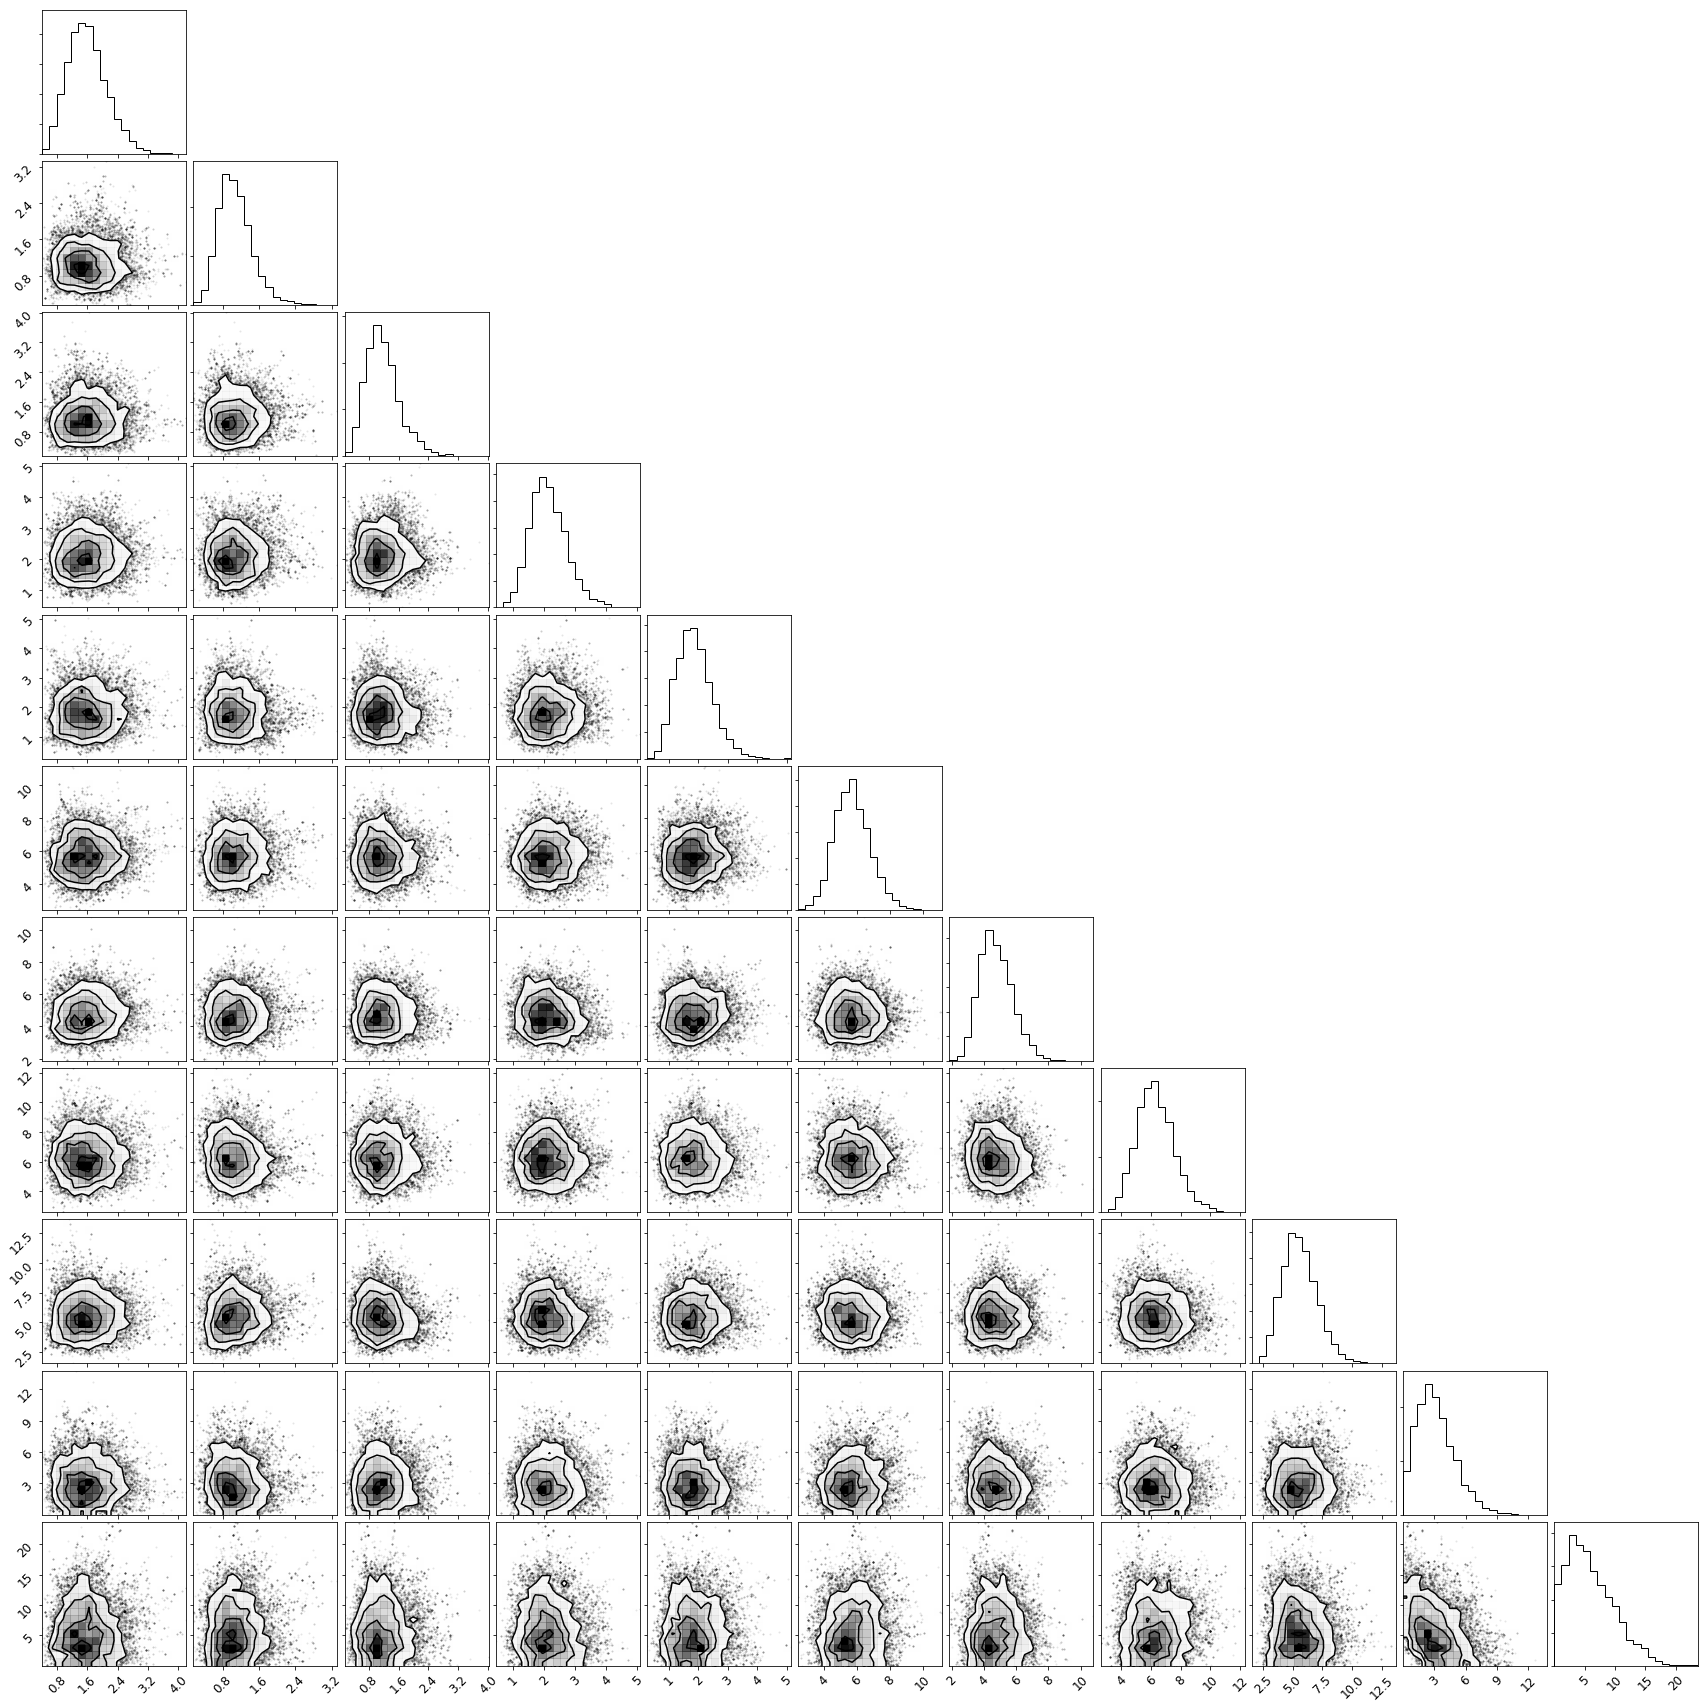

In [73]:
fig = corner.corner(hierarchical_one.chains[10000:]*hierarchical_one.bin_areas[0][0]*(100/719))
fig.savefig('corner_11x1_1014.pdf')

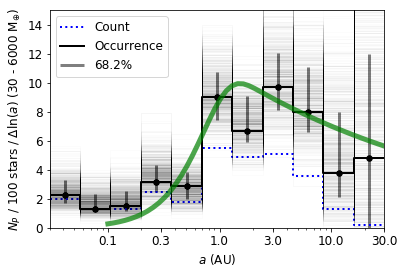

In [174]:
matplotlib.rcParams.update({'font.size': 12})
chains_db = pd.read_csv('occur_chains_11x1_1014.csv')

binwidth = allbins[0][0][1] - allbins[0][0][0]

# Do simple counting.
simple_counts = []
for n in np.arange(hierarchical_one.nbins):
    a1 = np.exp(allbins[n][0][0])
    a2 = np.exp(allbins[n][0][1])
    npl = len(planets.query('mass >= 0.1 and axis >= @a1 and axis < @a2'))
    simple_counts.append(npl)    
simple_counts = np.array(simple_counts)*(100/719)/binwidth

a_chains = np.empty((0, len(chains_db)))
for n in np.arange(hierarchical_one.nbins):
    a_chains = np.append(a_chains, np.array([chains_db['gamma{}'.format(n)]]), axis=0)
a_chains *= hierarchical_one.bin_areas[0][0]*(100/719)/binwidth

# Record modes & medians.
a_medians = np.median(a_chains, axis=1)
a_sqvars  = np.std(a_chains, axis=1)
a_modes = []
a_159 = []
a_841 = []
a_682 = []

for n in np.arange(hierarchical_one.nbins):
    chains = np.array([chains_db['gamma{}'.format(n)]])*hierarchical_one.bin_areas[0][0]*(100/719)
    hist, bin_edges = np.histogram(chains, bins=40, range=(np.percentile(chains, 2), np.percentile(chains, 95)))
    a_modes.append(bin_edges[np.argmax(hist)])
    a_159.append(np.percentile(chains, 15.9))
    a_841.append(np.percentile(chains, 84.1))
    a_682.append(np.percentile(chains, 68.2))
a_modes = np.array(a_modes)/binwidth
a_159 = np.array(a_159)/binwidth
a_841 = np.array(a_841)/binwidth
a_682 = np.array(a_682)/binwidth

#pdb.set_trace()

fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_xticks((0.1, 0.3, 1, 3, 10, 30))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

ax.set_xlabel(r'$a$ (AU)')
#ax.set_ylabel(r'Planets per 100 stars (30 - 6000 $\mathrm{M_{\oplus}}$)')
ax.set_ylabel(r'$N_P$ / 100 stars / $\Delta$ln($a$) (30 - 6000 $\mathrm{M_{\oplus}}$)')

ax.set_xlim([np.exp(hierarchical_one.lna_edges[0]), np.exp(hierarchical_one.lna_edges[-1])])
#ax.set_ylim([0, 10])
ax.set_ylim([0, 15])
lnaw = hierarchical_one.lna_edges[1] - hierarchical_one.lna_edges[0]

# Plot just-counting, no-completeness histogram.
ax.step(np.insert(np.exp(hierarchical_one.lna_edges[:-1] + lnaw), 0, np.exp(hierarchical_one.lna_edges[0])), 
        np.insert(simple_counts, 0, simple_counts[0]), lw=2, c='blue', linestyle=':', label='Count')

# Plot mode & 68.2% CI.
ax.scatter(np.exp(hierarchical_one.lna_edges[:-1] + 0.5*lnaw), a_modes,
           color='black', s=30, label='_nolegend_')#label='Occurrence mode & CI')
ax.vlines(np.exp(hierarchical_one.lna_edges[:-2] + 0.5*lnaw), a_159[:-1],
          a_841[:-1], alpha=0.5, color='black', lw=3, label='68.2%')
# Show CI from 0 to 68.2 for the last bin.
ax.vlines(np.exp(hierarchical_one.lna_edges[-2] + 0.5*lnaw), 0,
          a_682[-1], alpha=0.5, color='black', lw=3, label='_nolegend_')

# Plot occurrence histogram.
ax.step(np.insert(np.exp(hierarchical_one.lna_edges[:-1] + lnaw), 0, np.exp(hierarchical_one.lna_edges[0])), 
        np.insert(a_modes, 0, a_modes[0]), color='black', lw=2, label='Occurrence')
#'''
for i in np.arange(1000):
    ax.step(np.insert(np.exp(hierarchical_one.lna_edges[:-1] + lnaw), 0, np.exp(hierarchical_one.lna_edges[0])), 
            np.insert(a_chains[:, np.random.randint(0, 10000)], 0, a_medians[0]), 
            color='black', lw=1, alpha=0.01, label='_nolegend_')
#'''  
# Broken power law comparison. Mock parameters for now.
ax.plot(axes, (100/719)*occbroken(axes, [80, -0.2, 0.8, 2]), lw=5, alpha=0.7, color='green')
ax.legend(loc=2) 

#fig.savefig('hist_11x1_1014_fancy_mode.png', dpi=1000, bbox_inches='tight')
#fig.savefig('hist_11x1_1014_fancy_mode.pdf', bbox_inches='tight')

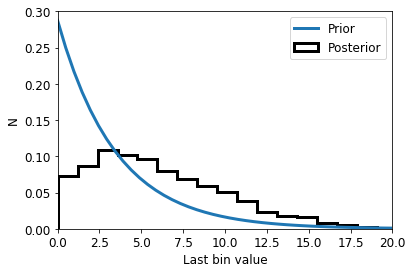

In [180]:
fig, ax = plt.subplots()

factor = hierarchical_one.bin_areas[0][0]*(100/719)
prior_grid = np.linspace(0, 4*hierarchical_one.ceiling*factor, num=50)

ax.plot(prior_grid, (hierarchical_one.Qints[-1]) * \
             np.exp(-hierarchical_one.Qints[-1]*prior_grid), lw=3, label='Prior')
ax.hist(factor*chains_db['gamma10'][1000:], bins=20, density=True, fill=False, 
        histtype='step', color='black', lw=3, label='Posterior')

ax.set_xlim([0, 20])
ax.set_ylim([0, 0.3])
ax.set_xlabel('Last bin value')
ax.set_ylabel('N')

ax.legend()
fig.savefig('last_bin_and_prior.png', dpi=1000, bbox_inches='tight')

In [90]:
recoveries_small = pd.read_csv('recoveries_small_earth.csv')
completey_small  = Completeness(recoveries_small)
completey_small.completeness_grid([0.01, 40], [2, 9000])

recoveries_outer = pd.read_csv('recoveries_outer_earth.csv')
completey_outer  = Completeness(recoveries_outer)
completey_outer.completeness_grid([0.01, 40], [2, 9000])

recoveries_planets = pd.read_csv('recoveries_planets_earth.csv')
completey_planets  = Completeness(recoveries_planets)
completey_planets.completeness_grid([0.01, 40], [2, 9000])

recoveries_pairs = pd.read_csv('recoveries_small_and_outer_earth.csv')
completey_pairs  = Completeness(recoveries_pairs)
completey_pairs.completeness_grid([0.01, 40], [2, 9000])

recoveries_all = pd.read_csv('recoveries_all_earth.csv')
completey_all  = Completeness(recoveries_all)
completey_all.completeness_grid([0.01, 40], [2, 9000])

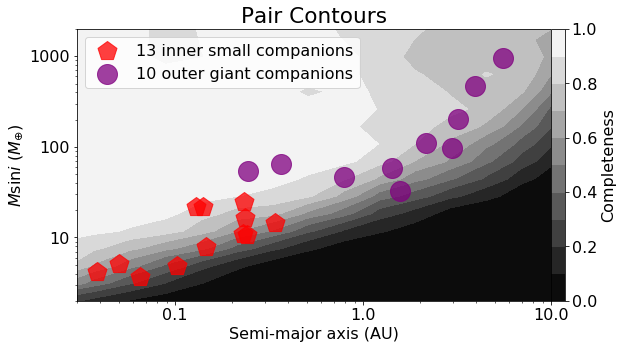

In [91]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticks((0.1, 1, 10))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_yaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

CS = ax.contourf(completey_pairs.grid[0], completey_pairs.grid[1],
                 completey_pairs.grid[2], 10, cmap=plt.cm.gray)

pair_outer = outers.query('axis > 0.23')
pair_inner = supers.query('hostname in @outernames')

matplotlib.rcParams.update({'font.size': 18})
ax.set_title('Pair Contours')

ax.scatter(pair_inner.axis, 317.8*pair_inner.mass, c='r', s=400, alpha=0.75, 
           label='{} inner small companions'.format(len(pair_inner)), marker='p')
ax.scatter(pair_outer.axis, 317.8*pair_outer.mass, s=400, c='purple', alpha=0.75, 
           label='{} outer giant companions'.format(len(pair_outer)))
ax.set_xlim([3*10**-2, 10])
ax.set_ylim([2, 2000])

ymin, ymax = ax.get_ylim()

matplotlib.rcParams.update({'font.size': 16})
ax.set_xlabel('Semi-major axis (AU)')
ax.set_ylabel(r'$M$sin$i$ ($M_{\oplus}$)')
ax.legend(loc=2)

plt.colorbar(mappable=CS, pad=0, label='Completeness')

fig.savefig('plots/pair_contours.png', dpi=500, bbox_inches='tight')
fig.savefig('plots/pair_contours.pdf', bbox_inches='tight')

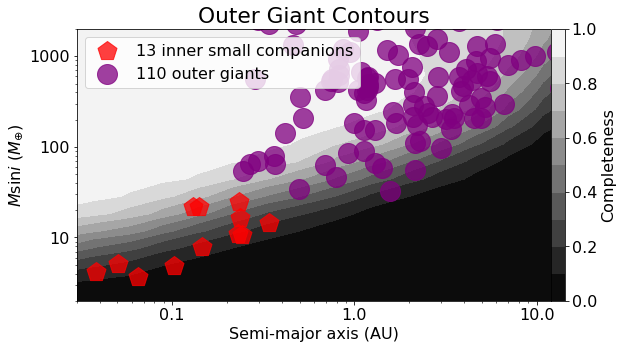

In [92]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticks((0.1, 1, 10))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_yaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

CS = ax.contourf(completey_outer.grid[0], completey_outer.grid[1],
                 completey_outer.grid[2], 10, cmap=plt.cm.gray)

pair_outer = all_outers.query('axis > 0.23')
pair_inner = supers.query('hostname in @outernames')

matplotlib.rcParams.update({'font.size': 18})
ax.set_title('Outer Giant Contours')

ax.scatter(pair_inner.axis, 317.8*pair_inner.mass, c='r', s=400, alpha=0.75, 
           label='{} inner small companions'.format(len(pair_inner)), marker='p')
ax.scatter(pair_outer.axis, 317.8*pair_outer.mass, s=400, c='purple', alpha=0.75, 
           label='{} outer giants'.format(len(pair_outer)))
ax.set_xlim([3*10**-2, 12])
ax.set_ylim([2, 2000])

ymin, ymax = ax.get_ylim()

matplotlib.rcParams.update({'font.size': 16})
ax.set_xlabel('Semi-major axis (AU)')
ax.set_ylabel(r'$M$sin$i$ ($M_{\oplus}$)')
#ax2.set_ylabel(r'$M$sin$i$ ($M_J$)')
ax.legend(loc=2)

plt.colorbar(mappable=CS, pad=0, label='Completeness')

fig.savefig('plots/pair_all_outers.png', dpi=500, bbox_inches='tight')
fig.savefig('plots/pair_all_outers.pdf', bbox_inches='tight')

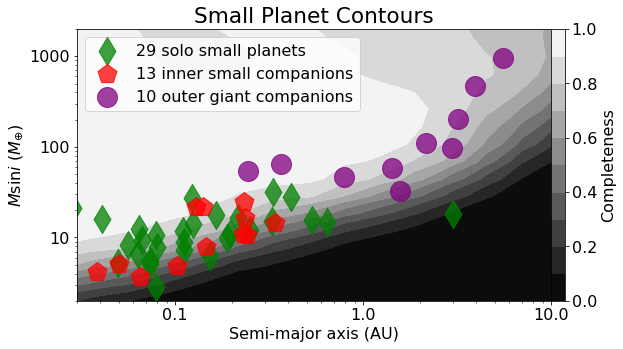

In [94]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticks((0.1, 1, 10))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_yaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

CS = ax.contourf(completey_small.grid[0], completey_small.grid[1],
                 completey_small.grid[2], 10, cmap=plt.cm.gray)

pair_outer = outers.query('axis > 0.23')
pair_inner = supers.query('hostname in @outernames')

matplotlib.rcParams.update({'font.size': 18})
ax.set_title('Small Planet Contours')
ax.scatter(solos.axis, 317.8*solos.mass, c='g', s=400, alpha=0.75, 
           label='{} solo small planets'.format(len(solos)), marker='d')
ax.scatter(pair_inner.axis, 317.8*pair_inner.mass, c='r', s=400, alpha=0.75, 
           label='{} inner small companions'.format(len(pair_inner)), marker='p')
ax.scatter(pair_outer.axis, 317.8*pair_outer.mass, s=400, c='purple', alpha=0.75, 
           label='{} outer giant companions'.format(len(pair_outer)))
ax.set_xlim([3*10**-2, 10])
ax.set_ylim([2, 2000])

ymin, ymax = ax.get_ylim()
#ax2.set_ylim((ymin/317.8,ymax/317.8))
#ax2.plot([],[])

matplotlib.rcParams.update({'font.size': 16})
ax.set_xlabel('Semi-major axis (AU)')
ax.set_ylabel(r'$M$sin$i$ ($M_{\oplus}$)')
#ax2.set_ylabel(r'$M$sin$i$ ($M_J$)')
ax.legend(loc=2)

plt.colorbar(mappable=CS, pad=0, label='Completeness')

fig.savefig('plots/small_planet_contours.png', dpi=500, bbox_inches='tight')
fig.savefig('plots/small_planet_contours.pdf', bbox_inches='tight')

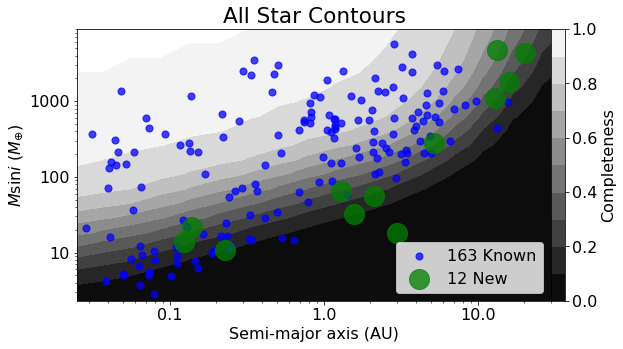

In [76]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticks((0.1, 1, 10))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_yaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

CS = ax.contourf(completey_all.grid[0], completey_all.grid[1],
                 completey_all.grid[2], 10, cmap=plt.cm.gray)

#pair_outer = outers.query('axis > 0.23')
#pair_inner = supers.query('hostname in @outernames')

matplotlib.rcParams.update({'font.size': 18})
ax.set_title('All Star Contours')
ax.scatter(planets_old.axis, 317.8*planets_old.mass, c='b', s=50, alpha=0.75, 
           label='{} Known'.format(len(planets_old)))
ax.scatter(planets_new.axis, 317.8*planets_new.mass, s=400, c='g', alpha=0.75, 
           label='{} New'.format(len(planets_new)))

ax.set_xlim([2.5*10**-2, 30])
ax.set_ylim([2.3, 9000])

ymin, ymax = ax.get_ylim()

matplotlib.rcParams.update({'font.size': 16})
ax.set_xlabel('Semi-major axis (AU)')
ax.set_ylabel(r'$M$sin$i$ ($M_{\oplus}$)')
ax.legend(loc=4)

plt.colorbar(mappable=CS, pad=0, label='Completeness')

fig.savefig('plots/all_contours.png', dpi=500, bbox_inches='tight')
fig.savefig('plots/all_contours.pdf', bbox_inches='tight')

NameError: name 'completey_planets' is not defined

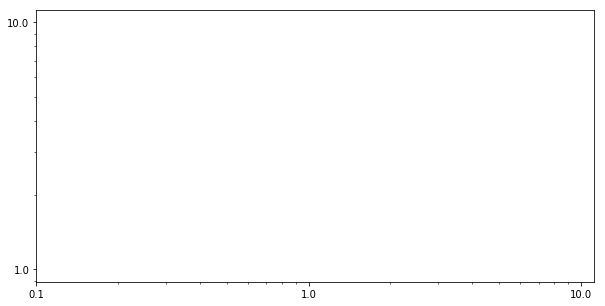

In [30]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticks((0.1, 1, 10))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_yaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

CS = ax.contourf(completey_planets.grid[0], completey_planets.grid[1],
                 completey_planets.grid[2], 10, cmap=plt.cm.gray)

pair_outer = outers.query('axis > 0.23')
pair_inner = supers.query('hostname in @outernames')

matplotlib.rcParams.update({'font.size': 18})
ax.set_title('All Planet Contours')
ax.scatter(planets_old.axis, 317.8*planets_old.mass, c='b', s=50, alpha=0.75, 
           label='{} Known'.format(len(planets_old)))
ax.scatter(planets_new.axis, 317.8*planets_new.mass, s=400, c='g', alpha=0.75, 
           label='{} New'.format(len(planets_new)))

ax.set_xlim([2.5*10**-2, 30])
ax.set_ylim([2.3, 9000])

ymin, ymax = ax.get_ylim()

matplotlib.rcParams.update({'font.size': 16})
ax.set_xlabel('Semi-major axis (AU)')
ax.set_ylabel(r'$M$sin$i$ ($M_{\oplus}$)')
ax.legend(loc=4)

plt.colorbar(mappable=CS, pad=0, label='Completeness')

fig.savefig('plots/all_planet_contours.png', dpi=500, bbox_inches='tight')
fig.savefig('plots/all_planet_contours.pdf', bbox_inches='tight')

## Make sampling dataframes for planet subsets.

In [217]:
samples_all = pd.read_csv('../samples_all_1000.csv').sample(200).reset_index(drop=True)
samples_med = samples_all.median()

columns = [col for col in samples_all.columns if ('_M' in col or '_a' in col)]
samples_all = samples_all[columns]
planetnames = np.unique([x[:-2] + x[-1] for x in samples_all.columns]) 

# Trim out planets that don't belong in each sample.
#columns_outers = [col for col in samples_all.columns if col[:-2] in list(supers.hostname)]
#columns_small = [col for col in samples_all.columns if col[:-2] in list(all_outers.hostname)]
columns_outers = []
colums_small = []
for planet in planetnames:
    a_col = planet[:-2] + '_a' + planet[-1]
    M_col = planet[:-2] + '_M' + planet[-1]
    if (samples_med[a_col] > 0.2) and (samples_med[M_col] > 0.08) and planet[:-2] in list(supers.hostname):
        columns_outers.append(a_col)
        columns_outers.append(M_col)
    if samples_med[M_col] < 0.11 and planet[:-2] in list(all_outers.hostname):
        columns_small.append(a_col)
        columns_small.append(M_col)

samples_small = samples_all[columns_small]
for col in columns_small:
    if '_M' in col:
        samples_small[col] *= 317.8
        
samples_outers = samples_all[columns_outers]
for col in columns_outers:
    if '_M' in col:
        samples_outers[col] *= 317.8

104067_a1 104067_M1 0.267014724700186
10697_a1 10697_M1 2.1542990713026526
107148_a1 107148_M1 0.36731975652359056
Outer
107148_a2 107148_M2 0.1408501845464908
108874_a1 108874_M1 1.0511401136884546
108874_a2 108874_M2 2.8257886677458615
114729_a1 114729_M1 2.0939130248625473
114762_a1 114762_M1 0.3522505499166161
114783_a1 114783_M1 1.1642103628358476
114783_a2 114783_M2 4.9675694406362485
115617_a1 115617_M1 0.21517949468859404
115617_a2 115617_M2 0.049596344589626945
117176_a1 117176_M1 0.47634479846645916
117207_a1 117207_M1 3.7412979360956173
11964a_a1 11964a_M1 3.18299506303374
Outer
11964a_a2 11964a_M2 0.2313048170358753
120066_a1 120066_M1 28.767240263917863
120136_a1 120136_M1 0.048668853561052425
126614_a2 126614_M2 2.291654039034767
12661_a1 12661_M1 0.8258890086968694
12661_a2 12661_M2 2.866367322246937
128311_a1 128311_M1 1.7417779534963183
128311_a2 128311_M2 1.0884228806493446
130322_a1 130322_M1 0.09295362412316559
1326_a1 1326_M1 0.07327263426892192
134987_a1 134987_M1

In [268]:
outerbins = lngrid(0.2, 30., 30., 317.8*20, 5, 4) 
hierarchical_outer = Hierarchy(samples_outers, completey_small, bins=outerbins)

In [269]:
hierarchical_outer.max_like()

In [271]:
hierarchical_outer.sample()

  2%|▏         | 16/1000 [03:04<3:16:07, 11.96s/it]Traceback (most recent call last):
  File "/Users/lee/anaconda/lib/python3.7/site-packages/emcee/ensemble.py", line 545, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-267-0b884f8259cb>", line 156, in lnpost
    return self.lnlike(theta) + self.lnprior(theta) # Leave out GP for now
  File "<ipython-input-267-0b884f8259cb>", line 117, in lnlike
    lna_av, lnm_av, theta)
  File "<ipython-input-267-0b884f8259cb>", line 81, in occurrence
    ia[ia < 0] = 0
KeyboardInterrupt
  2%|▏         | 16/1000 [03:06<3:11:36, 11.68s/it]

emcee: Exception while calling your likelihood function:
  params: [3.15163516e+00 2.96195343e-02 9.30643856e-03 2.77582392e-02
 2.62314562e+00 2.06619164e-02 1.23243360e-02 1.42037760e-02
 3.62729959e+00 1.74018422e+00 8.53116913e-01 6.80876302e-03
 3.09218821e-02 1.38891630e-02 9.91212613e-01 1.23265329e-02
 1.37121718e-02 6.39105888e-03 2.35253421e-03 1.04912987e-02]
  args: []
  kwargs: {}
  exception:


KeyboardInterrupt: 

In [233]:
nsuperstars = len(np.unique(supers.hostname))
nouterstars = len(np.unique(planets.query('axis > 0.23 and mass >= 0.1').hostname))

In [239]:
area  = hierarchical_outer.bin_areas[0][0]
rates = area * np.exp(hierarchical_outer.mlvalues[:, 0])
total = np.sum(rates)
error = np.sum(total * hierarchical_outer.mlvalues[:, 1])

print('Total expected planets:', total, '+/-', error)
print('Bin-wide planets per star:', total/nsuperstars/(2), '+/-', error/nsuperstars)

Total expected planets: 22.865293734669095 +/- inf
Bin-wide planets per star: 0.39422920232188097 +/- inf


In [261]:
hierarchical_inner = Hierarchy(samples_small, completey_outer, 
                               bins=np.array([[[np.log(0.023), np.log(1)], 
                                               [np.log(2.), np.log(30)]]]))

In [228]:
len(hierarchical_inner.pop_med.query('msini < 30 and axis < 1'))

14

In [264]:
hierarchical_inner.max_like()

> <ipython-input-257-76634e344a48>(44)max_like()
-> Q = 0
(Pdb) continue
> <ipython-input-257-76634e344a48>(58)max_like()
-> ml, uml = np.log(nplanets/Q), 1/np.sqrt(nplanets)
(Pdb) Q
0.6537466723094512
(Pdb) Q/self.bin_areas[0][0]
0.06399573618963239
(Pdb) continue


In [266]:
area  = hierarchical_inner.bin_areas[0][0]
total = area * np.exp(hierarchical_inner.mlvalues[:, 0])[0]
error = total * hierarchical_inner.mlvalues[:, 1][0]

print('Total expected planets:', total, '+/-', error)
print('Bin-wide planets per star:', total/nouterstars, '+/-', error/nouterstars)

Total expected planets: 203.13853350289392 +/- 56.34049219748027
Bin-wide planets per star: 2.507883129665357 +/- 0.6955616320676576


In [ ]:
with open('names_all.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['name'])
    for val in np.unique(specmatch.name):
        writer.writerow([val])

with open('names_planets.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['name'])
    for val in np.unique(planets.hostname):
        writer.writerow([val])
        
with open('names_small.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['name'])
    for val in np.unique(supers.hostname):
        writer.writerow([val])
        
with open('names_outer.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['name'])
    for val in np.unique(all_outers.hostname):
        writer.writerow([val])
        
with open('names_small_and_outer.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['name'])
    for val in np.unique(outers.hostname):
        writer.writerow([val])